# Limpeza de Dados

A limpeza de dados é o processo de detecção e correção de registros incorretos ou corrompidos em um conjunto de dados. Refere-se à identificação e, em seguida, a substituição, modificação ou exclusão de partes incompletas, imprecisas ou irrelevantes. Em geral, a limpeza de dados leva a uma sequência de tarefas que visam melhorar a qualidade dos dados. Algumas dessas tarefas incluem não só lidar com dados ausentes e duplicados, mas também remover dados ruidosos, inconsistentes e outliers. Esta seção apresenta cada uma dessas tarefas através de uma versão adaptada da tabela \textit{Artists}, bem como as demais tabelas do nosso conjunto de dados.

In [1]:
# Importando os pacotes necessários
import pandas as pd
import numpy as np
from scipy import stats

from fuzzywuzzy import fuzz
from itertools import combinations

pd.set_option('display.max_columns', 5)

In [2]:
# Lendo os dados
df = pd.read_csv('../dataset/spotify_artists_info_edited.csv', sep='\t', encoding='utf-8')
df.head(10)

,artist_id,name,...,genres,image_url
0,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,...,"['permanent wave', 'pop']",https://i.scdn.co/image/4ffd6710617d289699cc0d...
1,6Te49r3A6f5BiIgBRxH7FH,Ninho,...,"['french hip hop', 'pop urbaine']",https://i.scdn.co/image/ab67616d0000b2733f12b1...
2,4QrBoWLm2WNlPdbFhmlaUZ,KEVVO,...,"['perreo', 'reggaeton', 'reggaeton flow', 'tra...",https://i.scdn.co/image/9a75b11e5080f576bdff76...
3,1McMsnEElThX1knmY4oliG,Olivia Rodrigo,...,"['alt z', 'pop', 'post-teen pop']",https://i.scdn.co/image/5fb1f691c5d3cdbc54e193...
4,6KImCVD70vtIoJWnq6nGn3,Harry Styles,...,"['pop', 'post-teen pop']",https://i.scdn.co/image/b2163e7456f3d618a0e2a4...
5,6TOKWuw816UU34AE4MCZqr,Beltito,...,NaN,NaN
6,7F2utINZ6tSokSiZTQBE27,Guè Pequeno,...,"['italian hip hop', 'italian pop']",https://i.scdn.co/image/8c0ddb6022be1bbb4795cb...
7,2kCcBybjl3SAtIcwdWpUe3,Lil Peep,...,"['emo rap', 'lgbtq+ hip hop']",https://i.scdn.co/image/06404029eb0ce3b6f3b9bc...
8,7b79bQFziJFedJb75k6hFt,Tion Wayne,...,"['london rap', 'uk hip hop']",https://i.scdn.co/image/cd5bce94c304c5cd608eda...
9,2UZIAOlrnyZmyzt1nuXr9y,Nicki Nicole,...,"['argentine hip hop', 'r&b argentino', 'trap a...",https://i.scdn.co/image/a5f4ce02d179a6f41fc430...


## Dados ausentes 

Representam um obstáculo para a criação da maioria dos modelos de Aprendizado de Máquina e outras análises. Portanto, é necessário identificar campos para os quais não há dados e, em seguida, compensá-los adequadamente. Dados ausentes podem ocorrer quando nenhuma informação é fornecida para um ou mais registros (ou atributos inteiros) da base de dados. Em um \textit{Pandas DataFrame}, os dados ausentes são representados como `None` ou `NaN` (\textit{Not a Number}), embora `NaN` seja o marcador de valor ausente padrão por razões de velocidade e conveniência computacional. 

Após importar pacotes necessários e carregar o conjunto de dados, inicia-se o processo de limpeza de dados. Para facilitar a detecção, o \textit{Pandas} fornece a função `isna()` para identificar valores ausentes em um \textit{DataFrame}. A função retorna uma matriz \textit{booleana} indicando se cada elemento correspondente está faltando (`True`) ou não (`False`):

In [3]:
# Esta célula identifica valores ausentes no Dataframe
# e exibe as três primeiras linhas
pd.set_option('display.max_columns', 5)
df.isna().head(3)

,artist_id,name,...,genres,image_url
0,False,False,...,False,False
1,False,False,...,False,False
2,False,False,...,False,False


De acordo com o exemplo anterior, o conjunto de dados está aparentemente completo. Porém, tal resposta não é suficiente para descartar a hipótese de que existem dados ausentes. Para uma melhor averiguação, pode-se resumir cada coluna no \textit{DataFrame} \textit{booleano} somando os valores `False=0` e `True=1`. Tal processo retorna  o número de valores ausentes no \textit{DataFrame}. Também pode-se dividir cada valor pelo número total de linhas, resultando na porcentagem de tais ausências, conforme o exemplo a seguir.

In [4]:
# Calcula o total e a % de valores ausentes
num_ausentes = df.isna().sum() 
porc_ausentes = df.isna().sum() * 100 / len(df)
# DataFrame com as informações computadas acima
df_ausentes = pd.DataFrame({
    'Coluna': df.columns,
    'Dados ausentes': num_ausentes,
    'Porcentagem': porc_ausentes
})
df_ausentes

,Coluna,Dados ausentes,Porcentagem
artist_id,artist_id,0,0.00
name,name,0,0.00
followers,followers,0,0.00
popularity,popularity,62,9.92
genres,genres,40,6.40
image_url,image_url,10,1.60


O \textit{DataFrame} resultante contém 62 popularidades, 40 listas de gêneros e dez url de imagens ausentes, resultando em 9,9%, 6,4% e 1,6% de registros de cada coluna, respectivamente. Após essa identificação, é necessário tratar esses dados. A abordagem mais simples é eliminar todos os registros que contenham valores ausentes. No \textit{Pandas}, o método `dropna()` permite analisar e descartar linhas/colunas com valores nulos. O parâmetro `axis` determina a dimensão em que a função atuará: `axis = 0` remove todas as \textbf{linhas} que contêm valores nulos, e `axis = 1` remove \textbf{colunas}, conforme o seguinte exemplo.

In [5]:
# Elimina linhas com valores ausentes
novo_df = df.dropna(axis=0)
print(f"""\
Nº de linhas do DF original: {len(df)}
Nº de linhas do DF novo: {len(novo_df)}
Nº de linhas com pelo menos 1 valor ausente: {
(len(df) - len(novo_df))}""")

Nº de linhas do DF original: 625
Nº de linhas do DF novo: 529
Nº de linhas com pelo menos 1 valor ausente: 96


In [6]:
# Eliminando colunas com valores ausentes
novo_df = df.dropna(axis=1)
print(f"""\
Nº de colunas do DF original: {len(df.columns)}
Nº de colunas do DF novo: {len(novo_df.columns)}
Nº de colunas com pelo menos 1 valor ausente: {
(len(df.columns) - len(novo_df.columns))}""")

Nº de colunas do DF original: 6
Nº de colunas do DF novo: 3
Nº de colunas com pelo menos 1 valor ausente: 3


O código dos exemplos anteriores removeram as linhas/colunas onde pelo menos um elemento está faltando. Ambas abordagens são particularmente vantajosas para amostras de grande volume de dados, onde os valores podem ser descartados sem distorcer significativamente a interpretação. Em geral, a estratégia de exclusão é utilizada quando o problema de falta de dados ocorre na maioria das linhas ou colunas do conjunto de dados. No entanto, apesar de ser uma solução simples, ela ainda apresenta o risco de perder dados potencialmente úteis.

Uma alternativa mais confiável para lidar com dados ausentes é a imputação. Em vez de descartar tais dados, a imputação procura substituir seus valores por outros. Nessa abordagem, os valores ausentes são inferidos a partir dos dados  existentes. Existem várias maneiras de imputar os dados, sendo a imputação por valor constante ou por estatísticas básicas (média, mediana ou moda) as mais simples, como o exemplo a seguir.

In [7]:
# Substituindo NaNs pela média de valores presentes
copia_df = df.copy()
copia_df['popularity'].fillna(copia_df['popularity'].mean(), inplace=True)
copia_df.sample(2)

,artist_id,name,...,genres,image_url
535,3SYnDj7btg9gFY7ps8m5d5,RANI,...,['uk pop'],https://i.scdn.co/image/4ec63484b11c4ca237b480...
367,3oSJ7TBVCWMDMiYjXNiCKE,Kane Brown,...,"['contemporary country', 'country road']",https://i.scdn.co/image/c1c4dca1973a866b372b64...


Além de técnicas simples, existem várias técnicas de imputação avançadas cuja escolha depende da utilização dos dados, por exemplo, depende de um modelo de aprendizado de máquina para inserir e avaliar com precisão os dados ausentes. A imputação múltipla e modelos preditivos podem ser mais precisos, e assim são mais comuns do que métodos mais simples. No entanto, não existe uma maneira ideal de compensar os valores ausentes, pois cada estratégia pode ter um desempenho melhor ou pior dependendo do conjunto de dado e dos tipos de dados ausentes. 

## Dados ruidosos

São dados que fornecem informações adicionais mas sem sentido, chamadas de ruído. Geralmente são gerados por alguma falha na coleta de dados, erros de entrada de dados, entre outros. Dados com ruído podem prejudicar resultados de análises e de modelos, como os de aprendizado de máquina, por exemplo. Tal problema pode ser solucionado a partir de diferentes abordagens, incluindo o método de Binning, Regressão e \textit{Clustering}. 

Aqui, o foco é o método de Binning, uma técnica de suavização de dados  para reduzir os efeitos de pequenos erros de observação. Os dados originais são divididos em segmentos de tamanhos iguais (\textit{bins}) e, em seguida, são substituídos por um valor geral calculado para cada intervalo. Cada segmento é tratado separadamente, onde a substituição de valores pode ser realizada através de valores médios ou limites. No \textit{Pandas}, o método Binning usa as funções `cut()` e `qcut()`, que parecem iguais mas são diferentes.

### `qcut`

De acordo com a documentação, `qcut()` é uma função de discretização baseada em quantis: ela procura dividir os dados em \textit{bins} usando percentis com base na distribuição da amostra. A maneira mais simples de usá-la é definir o número de quantis e deixar que o \textit{Pandas} descubra como dividir os dados. O exemplo a seguir discretiza a variável \textit{followers} de duas maneiras diferentes: criando cinco \textit{bins} de mesmo tamanho, e configurando três quantis rotulados como "alto", "médio" e "baixo".

In [8]:
# Discretizando:
# ... em 5 intervalos de tamanhos iguais
df['qcut_1'] = pd.qcut(df['followers'], q=5)
# ... usando três quantis
df['qcut_2'] = pd.qcut(df['followers'],  
    q=[0, .3, .7, 1], 
    labels=["baixo", "médio", "alto"])
df.head(3)

,artist_id,name,...,qcut_1,qcut_2
0,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,...,"(6020134.2, 77681514.0]",alto
1,6Te49r3A6f5BiIgBRxH7FH,Ninho,...,"(2373906.0, 6020134.2]",alto
2,4QrBoWLm2WNlPdbFhmlaUZ,KEVVO,...,"(134539.2, 790144.4]",baixo


### `cut`

Pode-se utilizar a função `cut()` para segmentar e ordenar os dados em \textit{bins}. Enquanto `qcut()` calcula o tamanho de cada \textit{bin}, garantindo que a distribuição dos dados nos compartimentos seja igual, a função `cut()` define bordas exatas dos compartimentos. Ou seja, não há garantia sobre a distribuição de itens em cada \textit{bin}. O exemplo a seguir corta os dados da variável \textit{followers} em quatro bins de tamanhos iguais.

In [9]:
# Discretizando em 4 bins
df['cut_1'] = pd.cut(
    df['followers'],
    bins=4)
df.head(3)

,artist_id,name,...,qcut_2,cut_1
0,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,...,alto,"(19420416.75, 38840782.5]"
1,6Te49r3A6f5BiIgBRxH7FH,Ninho,...,alto,"(-77630.463, 19420416.75]"
2,4QrBoWLm2WNlPdbFhmlaUZ,KEVVO,...,baixo,"(-77630.463, 19420416.75]"


Conforme mostrado a seguir, se você deseja uma distribuição igual dos valores em cada compartimento, use `qcut()`. Caso contrário, se você quiser definir seus próprios intervalos numéricos de categorias, use a função `cut()`.

In [10]:
df['qcut_1'].value_counts()

(6020134.2, 77681514.0]    125
(2373906.0, 6020134.2]     125
(790144.4, 2373906.0]      125
(134539.2, 790144.4]       125
(50.999, 134539.2]         125
Name: qcut_1, dtype: int64

In [11]:
df['cut_1'].value_counts()

(-77630.463, 19420416.75]    590
(19420416.75, 38840782.5]     28
(38840782.5, 58261148.25]      5
(58261148.25, 77681514.0]      2
Name: cut_1, dtype: int64

## Outliers

São amostras de dados que são claramente diferentes da tendência central. São geralmente criados por erros de coleta ou entrada de dados, e podem facilmente produzir valores discrepantes interferindo na qualidade de análises. A maneira mais simples de identificar outliers é observar os valores máximos e mínimos em cada variável para ver se eles estão muito fora da curva normal. O exemplo a seguir utiliza a função `describe()` para gerar estatísticas descritivas do conjunto de dados, incluindo os valores máximos e mínimos. 

In [12]:
pd.set_option('display.max_columns', 10)

df.describe().round().transpose()

,count,mean,std,min,25%,50%,75%,max
followers,625.0,4471046.0,8194928.0,51.0,222726.0,1256547.0,4809711.0,77681514.0
popularity,563.0,78.0,10.0,0.0,72.0,79.0,84.0,100.0


Para o recurso \textit{followers}, o valor máximo é 77.7 milhões de seguidores, enquanto o quartil de 75% é apenas 48 milhões. Portanto, artistas com mais de 77 milhões de seguidores podem ser outliers. Essa verificação geral é melhor realizada através da representação gráfica dos dados numéricos por meio de seus quartis. Para isso, pode-se utilizar box plots, onde os valores discrepantes são plotados como pontos individuais. O gráfico do exemplo a seguir mostra a distribuição da variável \textit{followers}.

<AxesSubplot:>

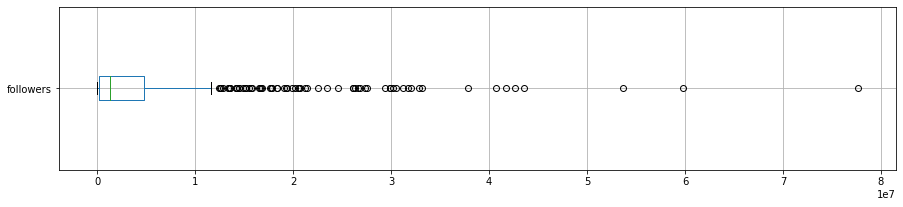

In [13]:
df.boxplot(column=['followers'], figsize=(15, 3), vert=False)

O exemplo ilustra que existem inúmeros pontos individuais (outliers) entre  12 a 78 milhões (aproximadamente). Embora tenha sido fácil detectar tais valores discrepantes, é preciso determinar as soluções adequadas para tratá-los. Assim como no caso de dados ausentes, o tratamento de outliers depende muito do conjunto de dados e do objetivo do projeto. Soluções possíveis incluem manter, ajustar ou apenas remover os dados discrepantes. Uma técnica comum para a remoção de outliers é  o método de Z-score, que considera como outliers e remove valores a uma determinada quantidade de desvios padrões da média. A quantidade desses desvios pode variar conforme o tamanho da amostra. No exemplo a seguir, para identificar e remover os outliers da coluna \textit{followers}, usou-se os z-scores de seus registros com a quantidade de desvios configurada para três.

In [14]:

z_scores = stats.zscore(df['followers']) # Z-scores dos valores da coluna 'followers'
abs_z_scores = np.abs(z_scores) # Obtendo os valores absolutos
novo_df = df[abs_z_scores < 3] # Filtra por desvios padrões < 3
print(f'{(len(df) - len(novo_df))} foram outliers removidos')

18 foram outliers removidos


## Dados duplicados

Aparecem em muitos contextos, especialmente durante a entrada ou coleta de dados. Por exemplo, ao usar um \textit{web scraper}, el pode coletar a mesma página web mais de uma vez ou as mesmas informações de duas páginas diferentes. Independente da causa, a duplicação de dados pode levar a conclusões incorretas, onde algumas observações podem ser consideradas mais comuns do que realmente são. O exemplo a seguir mostra quantas linhas estão duplicadas em cada coluna do conjunto de dados.

In [15]:
# Para cada coluna,
for coluna in df.columns:
    # Seleciona linhas duplicadas
    duplicatas_df = df[df.duplicated(coluna)]
    
    print(f"Total de linhas duplicadas "
          f"na {coluna}: {len(duplicatas_df)}")


Total de linhas duplicadas na artist_id: 0
Total de linhas duplicadas na name: 1
Total de linhas duplicadas na followers: 0
Total de linhas duplicadas na popularity: 569
Total de linhas duplicadas na genres: 136
Total de linhas duplicadas na image_url: 10
Total de linhas duplicadas na qcut_1: 620
Total de linhas duplicadas na qcut_2: 622
Total de linhas duplicadas na cut_1: 621


Nesse exemplo, apenas duas colunas do  \textit{DataFrame} não possuem duplicatas: \textit{artist\_id} e \textit{followers}. Além disso, nota-se que existem duas cópias do nome de um mesmo artista. Essa duplicidade de dados é a categoria mais simples de duplicatas: são cópias exatamente iguais de um mesmo registro. Para resolver, basta identificar os valores idênticos e removê-los. O \textit{Pandas} fornece o método `drop_duplicates()` que retorna um novo \textit{DataFrame} com linhas duplicadas removidas, como no exemplo a seguir.

In [16]:
novo_df = df.drop_duplicates() # Remove as linhas duplicadas
duplicatas_df = novo_df[novo_df.duplicated()] # calcula o total de linhas duplicadas
print(f"Total de linhas duplicadas: {len(duplicatas_df)}")

Total de linhas duplicadas: 0


Com apenas uma lista de registros com duplicatas, a melhor e mais simples solução é geralmente a remoção. Porém, com dados tabulares, a melhor solução é remover os dados duplicados com base em um conjunto de identificadores exclusivos. Por exemplo, existe a coluna de identificadores únicos dos artistas (\textit{artist\_id}), que facilita analisar se o nome duplicado identificado pode ser descartado, conforme o seguinte.

In [17]:
pd.set_option('display.max_columns', 5)
# Extrai o nome duplicado
nome_duplicado = df[df.duplicated(['name'])].name

# Linhas onde 'name' é igual ao nome duplicado
df.loc[df['name'].isin(nome_duplicado)]

,artist_id,name,...,qcut_2,cut_1
88,30vzHJVtI7JWEKqk40eOdz,Niack,...,baixo,"(-77630.463, 19420416.75]"
249,5uYe4bcAXlMP7d4mrOYkML,Niack,...,baixo,"(-77630.463, 19420416.75]"


Os resultados mostram dois artistas com o nome "Niack", mas com identificadores únicos diferentes. Logo, não se pode descartar uma das supostas cópias. Existem ainda outras formas de duplicação de dados mais complexas, onde mais de um registro é associado à mesma observação, porém seus valores não são completamente idênticos. Por exemplo, nomes próprios com e sem abreviação ou omissão de algum dos sobrenomes. Essa duplicação parcial é bem mais difícil de identificar, pois requer entender se realmente os registros duplicados dizem respeito ao mesmo objeto. Nesses casos, uma solução comum é utilizar funções de similaridade de strings. 

Uma ferramenta poderosa para esse problema é a biblioteca Python \textit{FuzzyWuzzy}, que usa a distância de Levenshtein para calcular as diferenças entre duas strings. No exemplo a seguir, nós utilizamos duas funções, `ratio()` e `partial_ratio()`, para encontrar cópias não idênticas de nomes de artistas. O código retorna dois prováveis casos de duplicação parcial. No primeiro, ao pesquisarmos a fundo, descobrimos que os dois nomes identificam duas artistas distintas. Portanto, não podemos remover essas supostas cópias. No entanto, no segundo caso, "Red Velvet" denomina o mesmo grupo feminino sul-coreano, porém o nome "Red Velvet - Irene & Seulgi" foi cadastrado na plataforma Spotify para representar a primeira subunidade do grupo (composto por Irene e Seulgi).

In [18]:
combinacoes = combinations(df.name, 2) # gera todas as combinações
for nome_1, nome_2 in list(combinacoes): # para cada tupla de nomes,
    partial_ratio = fuzz.partial_ratio(nome_1, nome_2) # similaridade parcial
    ratio = fuzz.ratio(nome_1, nome_2) # similaridade simples
    
    # Se os nomes forem parcialmente iguais, porém não identicos,
    if partial_ratio == 100 and ratio < 100 and ratio > 50:
        print(f'{nome_1} ({partial_ratio}) | {nome_2} ({ratio})')

The Blessed Madonna (100) | Madonna (54)
Red Velvet - IRENE & SEULGI (100) | Red Velvet (54)


## Conclusão

Este notebook apresentou como fazer a limpeza inicial de dados de dados.

O próximo notebook ([3.2.Integracao.ipynb](3.2.Integracao.ipynb)) apresenta como fazer a integração de dados de várias fontes.